In [1]:
%env CUDA_VISIBLE_DEVICES=6
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np
import os 

%matplotlib inline

env: CUDA_VISIBLE_DEVICES=6


In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
root_folder = 'Conv_VAE_log_results'
fixed_folder = root_folder + '/Fixed_results'
AE_folder = root_folder + '/AE_results'

if os.path.isdir(root_folder):
    !rm -r $root_folder
os.mkdir(root_folder)
os.mkdir(fixed_folder)
os.mkdir(AE_folder)

In [4]:
mnist_tanh = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])

In [5]:
batch_size = 50
train_loader, valid_loader, test_loader = mnist(batch_size = batch_size, valid=10000, transform=mnist_tanh)

fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.cuda()

In [6]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [7]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [8]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh(), flatten=False, last_fn=None):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [9]:
class Encoder(nn.Module):
    def __init__(self, latent_size=32, batchnorm=False, dropout=False, **optim_params):
        super().__init__()
    
        self.latent_size = latent_size
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, pool_layer=None)
            
        self.fce = FullyConnected([32*2*2, latent_size*2])
        
        self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 32*2*2)
        h = self.fce(flatten)
        self.mu, self.logvar = h.split(self.latent_size, dim=1)
        return self.mu, self.logvar
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        if self.training:
            std = logvar.mul(0.5).exp()
            h = self._sample(mu.shape[0]) * std + mu
        else:
            h = mu
        return h
    
    def _sample(self, n):
        return torch.randn([n, self.latent_size]).cuda()
    
    

In [10]:
class Decoder(nn.Module):
    def __init__(self, latent_size=32, batchnorm=False, dropout=False, **optim_params):
        super().__init__()
    
        self.latent_size = latent_size
        
        self.fcd = FullyConnected([latent_size, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self.optim = optim.Adam(self.parameters(), **optim_params)
        
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def forward(self, x):
        x = self.decode(x)
        return x
    

In [11]:
class Discriminator(nn.Module):
    def __init__(self, sizes, batchnorm=False, dropout=False, **optim_params):
        super().__init__()
        
        self.net = FullyConnected(sizes, dropout=dropout, 
                                  activation_fn=nn.LeakyReLU(0.2), 
                                  flatten=True).cuda()
        
        self.optim = optim.Adam(self.net.parameters(), **optim_params)
        
    def forward(self, x):
        return self.net(x)
        
    

In [12]:
torch.manual_seed(42)

latent_size = 2

encoder = Encoder(latent_size, batchnorm=False, dropout=0.2, lr=1e-4).cuda()
decoder = Decoder(latent_size, batchnorm=False, dropout=0.2, lr=1e-4).cuda()
D = Discriminator([latent_size, 32, 1], batchnorm=False, dropout=False, lr=1e-4).cuda()

train_log = []
test_log = []

batch_zeros = torch.zeros((batch_size, 1)).cuda()
batch_ones = torch.ones((batch_size, 1)).cuda()

fixed_z = torch.randn((batch_size, latent_size)).cuda()


In [13]:
print(encoder)
print(decoder)
print(D)

Encoder(
  (_conv1): ConvLayer(
    (model): Sequential(
      (0): Conv2d(1, 16, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
  )
  (_conv2): ConvLayer(
    (model): Sequential(
      (0): Conv2d(16, 32, kernel_size=(4, 4), stride=(2, 2))
      (1): ReLU()
    )
  )
  (_conv3): ConvLayer(
    (model): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
  )
  (fce): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=128, out_features=4, bias=True)
    )
  )
)
Decoder(
  (fcd): FullyConnected(
    (model): Sequential(
      (0): Linear(in_features=2, out_features=128, bias=True)
    )
  )
  (_deconv1): DeconvLayer(
    (model): Sequential(
      (0): ConvTranspose2d(32, 32, kernel_size=(3, 3), stride=(2, 2))
      (1): ReLU()
    )
  )
  (_deconv2): DeconvLayer(
    (model): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(4, 4), stride=(2, 2), output_padding=(1, 1))
      (1): ReLU()
    )
  )
  (

In [14]:
def train(epoch, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.cuda()
        
        # Discriminator
        encoder.optim.zero_grad()
        decoder.optim.zero_grad()
        D.optim.zero_grad()
        
        encoder.eval()
        z = torch.randn((batch_size, latent_size)).cuda()
        h = encoder(data)
        fake_pred = D(h)
        true_pred = D(z)
        
        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
        D_loss = 0.5*(fake_loss + true_loss)
        
        D_loss.backward()
        D.optim.step()
        encoder.train()
        
        # Reconstruction
        
        encoder.optim.zero_grad()
        decoder.optim.zero_grad()
        D.optim.zero_grad()
        
        h = encoder(data)
        output = decoder(h)
        fake_pred = D(h)
        
        R_loss = F.mse_loss(output, data, size_average=True) + F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
        
        R_loss.backward()
        encoder.optim.step()
        decoder.optim.step()
        
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' R = {:.4f}, D = {:.4f}'.format(R_loss.item(), D_loss.item())
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' R = {:.4f}, D = {:.4f}'.format(R_loss.item(), D_loss.item())
        if log is not None:
            log.append((R_loss.item(), D_loss.item()))
        print(line + losses)

In [15]:
def test(loader, epoch, log=None):
    test_size = len(loader)
    test_R_loss = 0.0
    test_D_loss = 0.0
    with torch.no_grad():
        for data, _ in loader:
            data = data.cuda()
            
            h = encoder(data)
            output = decoder(h)
            
            z = torch.randn((batch_size, latent_size)).cuda()
            
            fake_pred = D(h)
            true_pred = D(z)
            
            R_loss = F.mse_loss(output, data, size_average=True) + F.binary_cross_entropy_with_logits(fake_pred, batch_ones)
            
            fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
            true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones)
        
            D_loss = 0.5*(fake_loss + true_loss)
            
            test_R_loss += R_loss.item()
            test_D_loss += D_loss.item()

    test_R_loss /= test_size
    test_D_loss /= test_size
    report = 'Test losses: {:.4f}/{:.4f}\n'.format(test_R_loss, test_D_loss)

    if log is not None:
        log.append((test_R_loss, test_D_loss))
    with torch.no_grad():
        ae_data = decoder(encoder(fixed_data))
        ae_data = ae_data.data.cpu().numpy()
        fixed_gen = decoder(fixed_z).data.cpu().numpy()
        plot_mnist(ae_data, (5, 10))
        plot_mnist(fixed_gen, (5, 10))
    print(report)

In [16]:
def plot(train, test):
    plt.figure(figsize=(12,6))
    plt.plot(train[0], color='green', label="R - train")
    plt.plot(test[0], color='green', label="R - test", marker='o')
    plt.plot(train[1], color='blue', label="D - train")
    plt.plot(test[1], color='blue', label="D - test", marker='o')
    plt.ylabel("loss")
    plt.xlabel("epochs")
    plt.legend()
    plt.show()
    

/cephfs/home/seliverstov/oml/env/lib/python3.6/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


Train Epoch: 1 [0/50000 (0%)]	Losses  R = 1.4379, D = 0.6860
Train Epoch: 1 [10000/50000 (20%)]	Losses  R = 0.5214, D = 1.5632
Train Epoch: 1 [20000/50000 (40%)]	Losses  R = 1.1200, D = 0.6342
Train Epoch: 1 [30000/50000 (60%)]	Losses  R = 1.1840, D = 0.5876
Train Epoch: 1 [40000/50000 (80%)]	Losses  R = 1.0119, D = 0.6818
Train Epoch: 1 [50000/50000 (100%)]	Losses  R = 0.9169, D = 0.7197


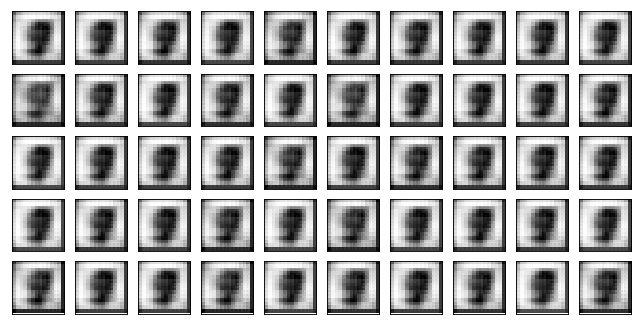

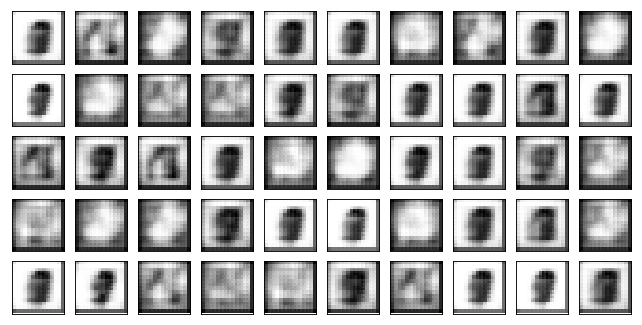

Test losses: 0.9229/0.7162

Train Epoch: 2 [0/50000 (0%)]	Losses  R = 0.9226, D = 0.7132
Train Epoch: 2 [10000/50000 (20%)]	Losses  R = 0.6004, D = 1.0232
Train Epoch: 2 [20000/50000 (40%)]	Losses  R = 1.0145, D = 0.6978
Train Epoch: 2 [30000/50000 (60%)]	Losses  R = 0.9404, D = 0.7145
Train Epoch: 2 [40000/50000 (80%)]	Losses  R = 0.9511, D = 0.7098
Train Epoch: 2 [50000/50000 (100%)]	Losses  R = 0.9422, D = 0.7055


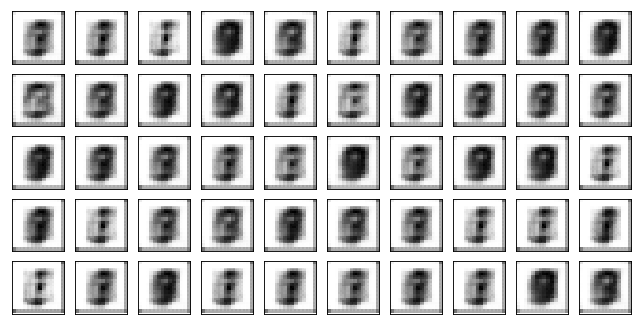

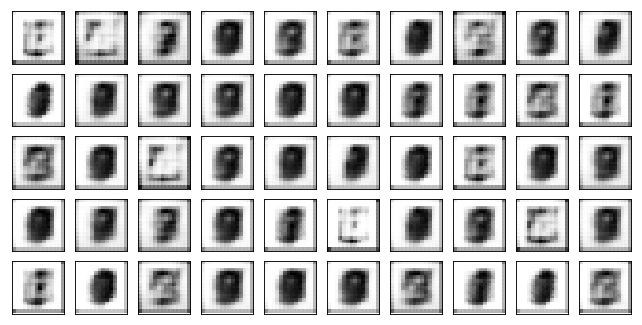

Test losses: 0.9332/0.7077

Train Epoch: 3 [0/50000 (0%)]	Losses  R = 0.9265, D = 0.7051
Train Epoch: 3 [10000/50000 (20%)]	Losses  R = 0.9260, D = 0.7068
Train Epoch: 3 [20000/50000 (40%)]	Losses  R = 0.9155, D = 0.7029
Train Epoch: 3 [30000/50000 (60%)]	Losses  R = 0.9118, D = 0.7026
Train Epoch: 3 [40000/50000 (80%)]	Losses  R = 0.9199, D = 0.6999
Train Epoch: 3 [50000/50000 (100%)]	Losses  R = 0.9059, D = 0.6999


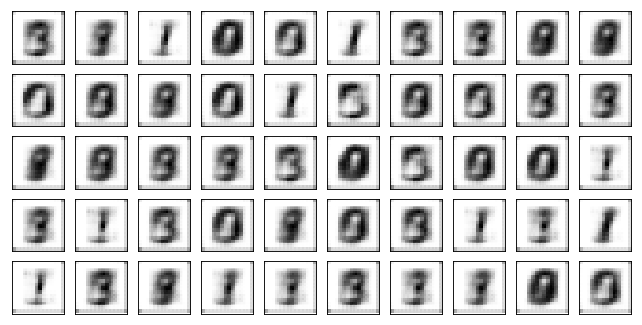

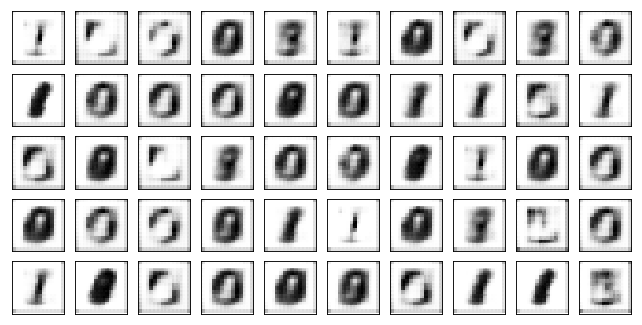

Test losses: 0.9134/0.6988

Train Epoch: 4 [0/50000 (0%)]	Losses  R = 0.9168, D = 0.6996
Train Epoch: 4 [10000/50000 (20%)]	Losses  R = 0.9115, D = 0.6964
Train Epoch: 4 [20000/50000 (40%)]	Losses  R = 0.9136, D = 0.6966
Train Epoch: 4 [30000/50000 (60%)]	Losses  R = 0.9022, D = 0.6965
Train Epoch: 4 [40000/50000 (80%)]	Losses  R = 0.9069, D = 0.6949
Train Epoch: 4 [50000/50000 (100%)]	Losses  R = 0.9063, D = 0.6951


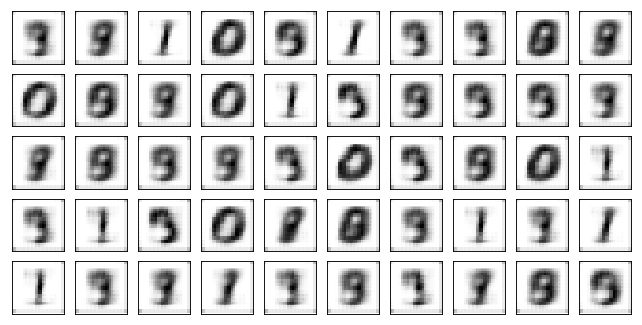

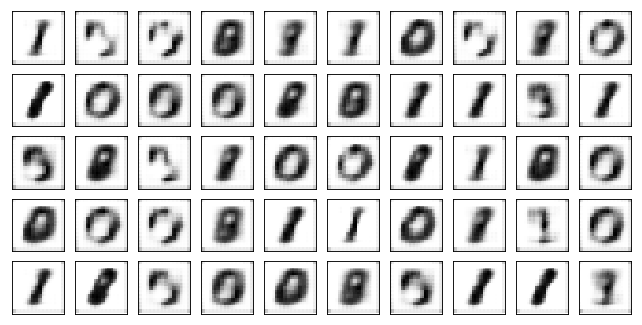

Test losses: 0.9096/0.6950

Train Epoch: 5 [0/50000 (0%)]	Losses  R = 0.9231, D = 0.6944
Train Epoch: 5 [10000/50000 (20%)]	Losses  R = 0.8953, D = 0.6939
Train Epoch: 5 [20000/50000 (40%)]	Losses  R = 0.9158, D = 0.6933
Train Epoch: 5 [30000/50000 (60%)]	Losses  R = 0.9091, D = 0.6917
Train Epoch: 5 [40000/50000 (80%)]	Losses  R = 0.9070, D = 0.6927
Train Epoch: 5 [50000/50000 (100%)]	Losses  R = 0.9110, D = 0.6928


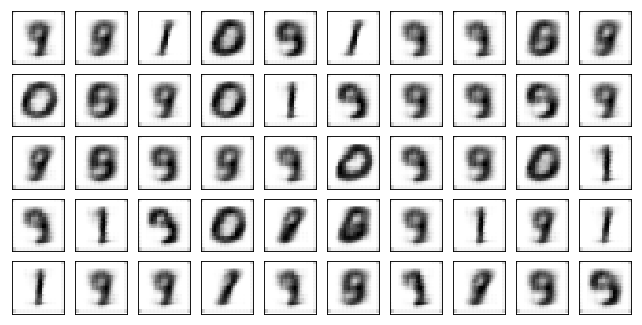

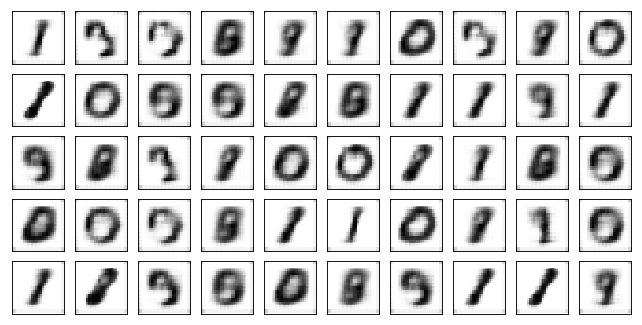

Test losses: 0.9095/0.6922

Train Epoch: 6 [0/50000 (0%)]	Losses  R = 0.9045, D = 0.6916
Train Epoch: 6 [10000/50000 (20%)]	Losses  R = 0.9066, D = 0.6918
Train Epoch: 6 [20000/50000 (40%)]	Losses  R = 0.8873, D = 0.6925
Train Epoch: 6 [30000/50000 (60%)]	Losses  R = 0.9178, D = 0.6915
Train Epoch: 6 [40000/50000 (80%)]	Losses  R = 0.8973, D = 0.6936
Train Epoch: 6 [50000/50000 (100%)]	Losses  R = 0.9175, D = 0.6955


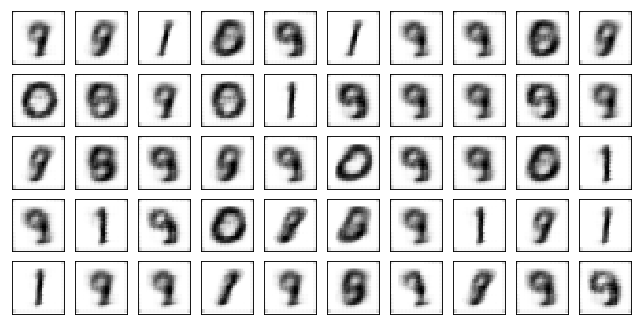

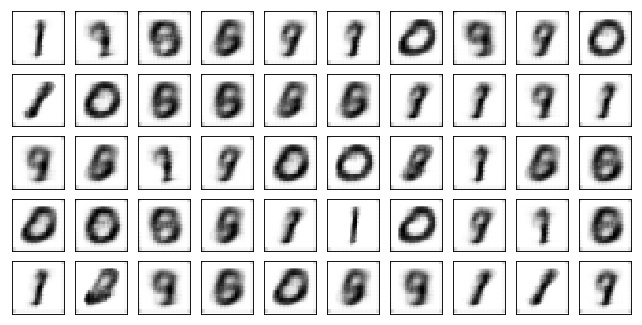

Test losses: 0.9037/0.6961

Train Epoch: 7 [0/50000 (0%)]	Losses  R = 0.8928, D = 0.6954
Train Epoch: 7 [10000/50000 (20%)]	Losses  R = 0.9081, D = 0.6972
Train Epoch: 7 [20000/50000 (40%)]	Losses  R = 0.9094, D = 0.6941
Train Epoch: 7 [30000/50000 (60%)]	Losses  R = 0.9118, D = 0.6947
Train Epoch: 7 [40000/50000 (80%)]	Losses  R = 0.8877, D = 0.6954
Train Epoch: 7 [50000/50000 (100%)]	Losses  R = 0.8995, D = 0.6934


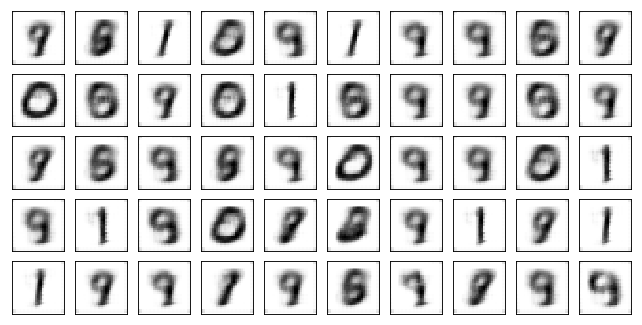

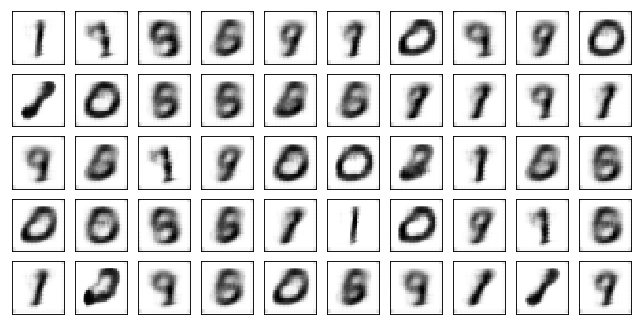

Test losses: 0.8960/0.6939

Train Epoch: 8 [0/50000 (0%)]	Losses  R = 0.8966, D = 0.6928
Train Epoch: 8 [10000/50000 (20%)]	Losses  R = 0.9223, D = 0.6948
Train Epoch: 8 [20000/50000 (40%)]	Losses  R = 0.8992, D = 0.6942
Train Epoch: 8 [30000/50000 (60%)]	Losses  R = 0.8951, D = 0.6942
Train Epoch: 8 [40000/50000 (80%)]	Losses  R = 0.8840, D = 0.6943
Train Epoch: 8 [50000/50000 (100%)]	Losses  R = 0.8770, D = 0.6935


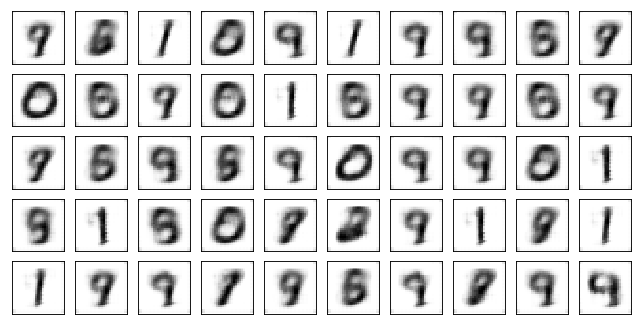

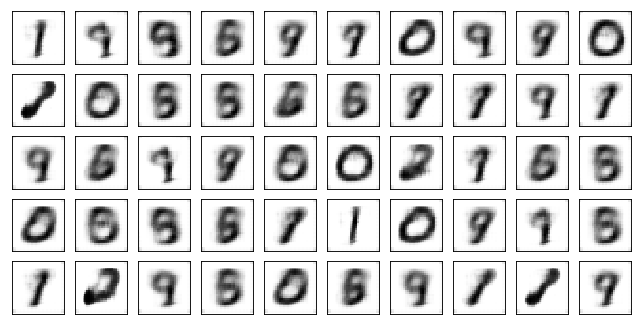

Test losses: 0.8933/0.6937

Train Epoch: 9 [0/50000 (0%)]	Losses  R = 0.8801, D = 0.6942
Train Epoch: 9 [10000/50000 (20%)]	Losses  R = 0.8869, D = 0.6941
Train Epoch: 9 [20000/50000 (40%)]	Losses  R = 0.8925, D = 0.6937
Train Epoch: 9 [30000/50000 (60%)]	Losses  R = 0.8837, D = 0.6944
Train Epoch: 9 [40000/50000 (80%)]	Losses  R = 0.8874, D = 0.6931
Train Epoch: 9 [50000/50000 (100%)]	Losses  R = 0.8973, D = 0.6931


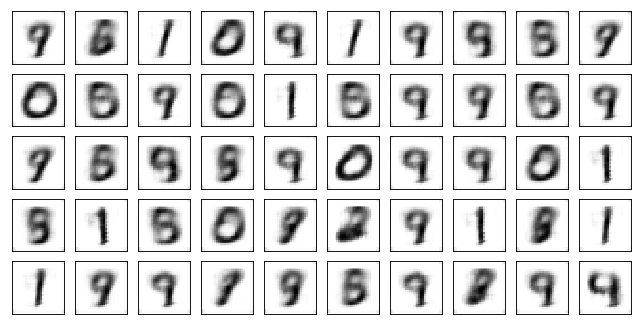

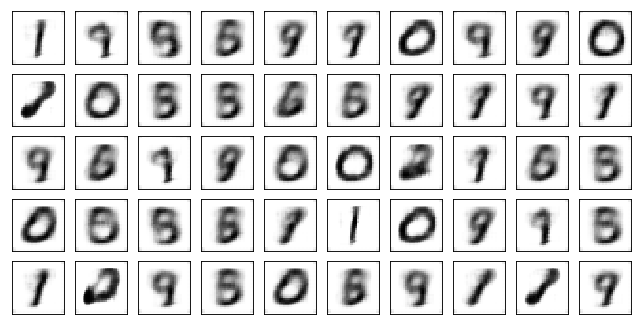

Test losses: 0.8894/0.6937

Train Epoch: 10 [0/50000 (0%)]	Losses  R = 0.9021, D = 0.6933
Train Epoch: 10 [10000/50000 (20%)]	Losses  R = 0.8886, D = 0.6935
Train Epoch: 10 [20000/50000 (40%)]	Losses  R = 0.8828, D = 0.6939
Train Epoch: 10 [30000/50000 (60%)]	Losses  R = 0.8953, D = 0.6927
Train Epoch: 10 [40000/50000 (80%)]	Losses  R = 0.8926, D = 0.6935
Train Epoch: 10 [50000/50000 (100%)]	Losses  R = 0.8849, D = 0.6932


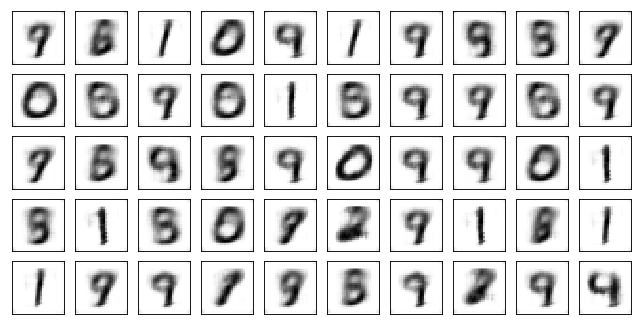

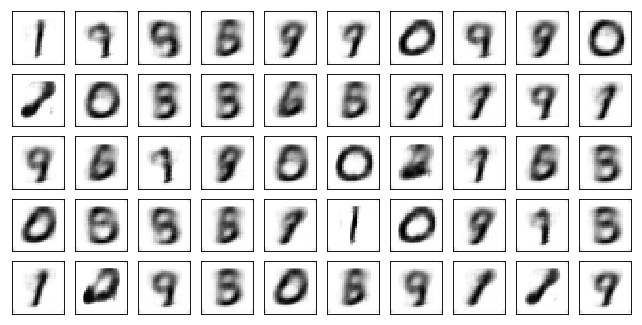

Test losses: 0.8867/0.6934



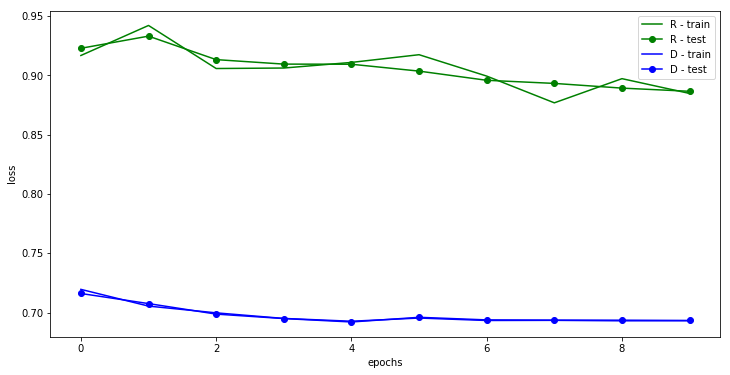

Train Epoch: 11 [0/50000 (0%)]	Losses  R = 0.8692, D = 0.6936
Train Epoch: 11 [10000/50000 (20%)]	Losses  R = 0.9107, D = 0.6939
Train Epoch: 11 [20000/50000 (40%)]	Losses  R = 0.8896, D = 0.6936
Train Epoch: 11 [30000/50000 (60%)]	Losses  R = 0.8948, D = 0.6925
Train Epoch: 11 [40000/50000 (80%)]	Losses  R = 0.8861, D = 0.6931
Train Epoch: 11 [50000/50000 (100%)]	Losses  R = 0.8798, D = 0.6933


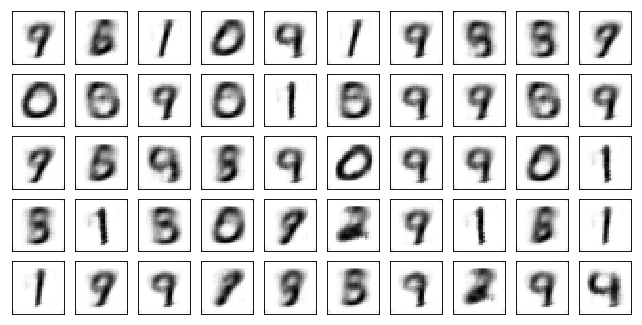

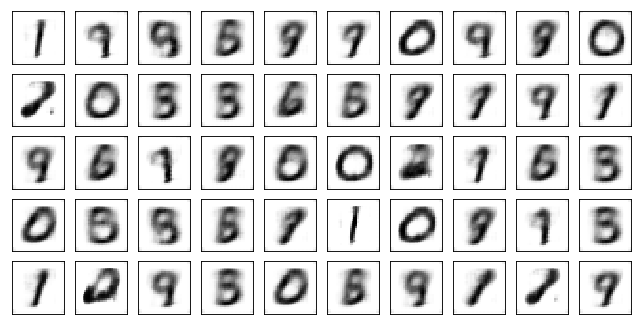

Test losses: 0.8839/0.6935

Train Epoch: 12 [0/50000 (0%)]	Losses  R = 0.9042, D = 0.6932
Train Epoch: 12 [10000/50000 (20%)]	Losses  R = 0.8993, D = 0.6933
Train Epoch: 12 [20000/50000 (40%)]	Losses  R = 0.8821, D = 0.6924
Train Epoch: 12 [30000/50000 (60%)]	Losses  R = 0.8782, D = 0.6930
Train Epoch: 12 [40000/50000 (80%)]	Losses  R = 0.8847, D = 0.6927
Train Epoch: 12 [50000/50000 (100%)]	Losses  R = 0.8928, D = 0.6930


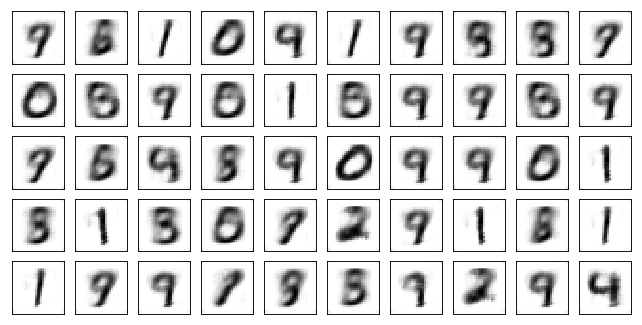

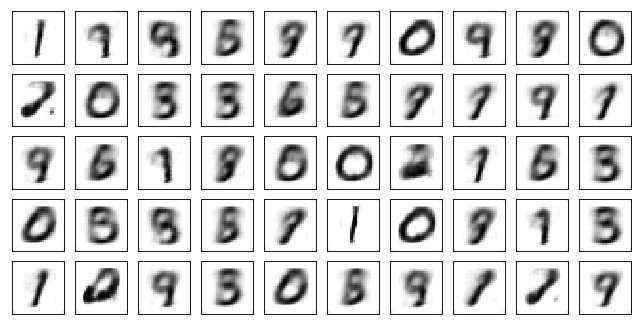

Test losses: 0.8827/0.6935

Train Epoch: 13 [0/50000 (0%)]	Losses  R = 0.8845, D = 0.6935
Train Epoch: 13 [10000/50000 (20%)]	Losses  R = 0.9096, D = 0.6929
Train Epoch: 13 [20000/50000 (40%)]	Losses  R = 0.8743, D = 0.6926
Train Epoch: 13 [30000/50000 (60%)]	Losses  R = 0.8729, D = 0.6939
Train Epoch: 13 [40000/50000 (80%)]	Losses  R = 0.8805, D = 0.6928
Train Epoch: 13 [50000/50000 (100%)]	Losses  R = 0.8796, D = 0.6944


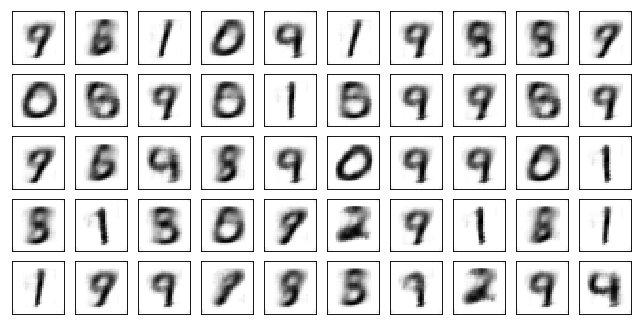

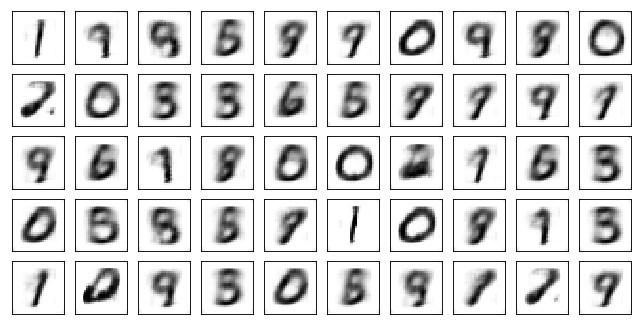

Test losses: 0.8804/0.6934

Train Epoch: 14 [0/50000 (0%)]	Losses  R = 0.8637, D = 0.6936
Train Epoch: 14 [10000/50000 (20%)]	Losses  R = 0.8879, D = 0.6932
Train Epoch: 14 [20000/50000 (40%)]	Losses  R = 0.8886, D = 0.6927
Train Epoch: 14 [30000/50000 (60%)]	Losses  R = 0.8678, D = 0.6931
Train Epoch: 14 [40000/50000 (80%)]	Losses  R = 0.8675, D = 0.6936
Train Epoch: 14 [50000/50000 (100%)]	Losses  R = 0.8676, D = 0.6934


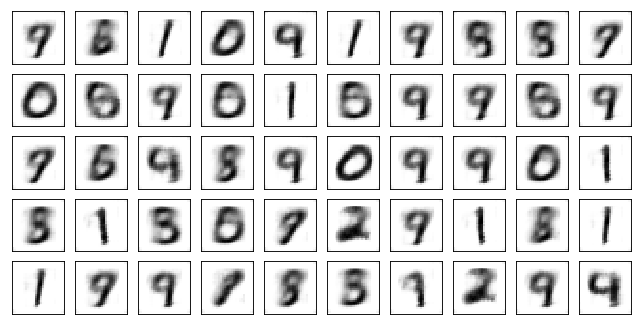

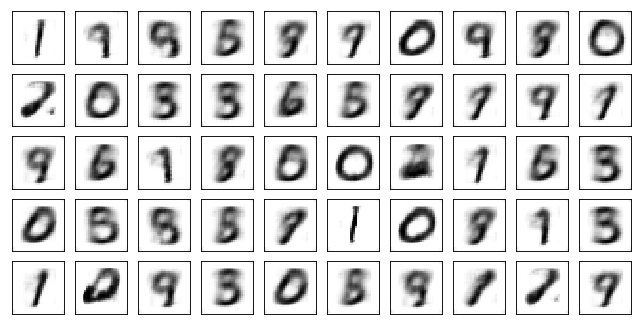

Test losses: 0.8792/0.6933

Train Epoch: 15 [0/50000 (0%)]	Losses  R = 0.8810, D = 0.6937
Train Epoch: 15 [10000/50000 (20%)]	Losses  R = 0.8744, D = 0.6931
Train Epoch: 15 [20000/50000 (40%)]	Losses  R = 0.8709, D = 0.6927
Train Epoch: 15 [30000/50000 (60%)]	Losses  R = 0.8830, D = 0.6929
Train Epoch: 15 [40000/50000 (80%)]	Losses  R = 0.8646, D = 0.6933
Train Epoch: 15 [50000/50000 (100%)]	Losses  R = 0.8626, D = 0.6946


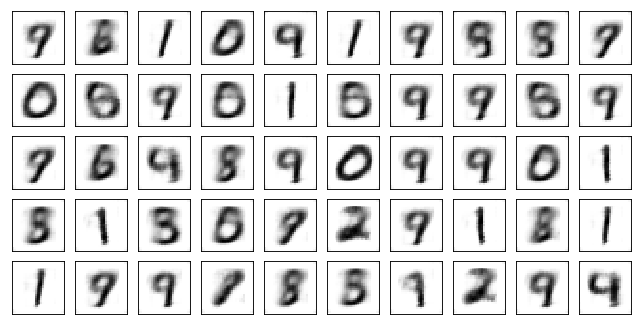

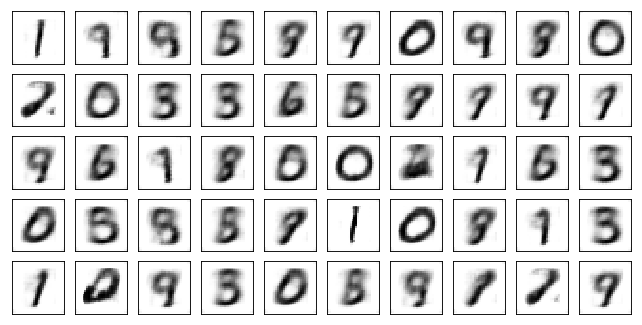

Test losses: 0.8781/0.6933

Train Epoch: 16 [0/50000 (0%)]	Losses  R = 0.8715, D = 0.6932
Train Epoch: 16 [10000/50000 (20%)]	Losses  R = 0.8735, D = 0.6933
Train Epoch: 16 [20000/50000 (40%)]	Losses  R = 0.9062, D = 0.6934
Train Epoch: 16 [30000/50000 (60%)]	Losses  R = 0.8765, D = 0.6938
Train Epoch: 16 [40000/50000 (80%)]	Losses  R = 0.8845, D = 0.6931
Train Epoch: 16 [50000/50000 (100%)]	Losses  R = 0.8531, D = 0.6935


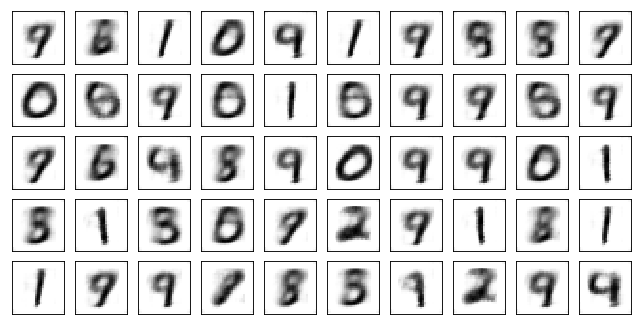

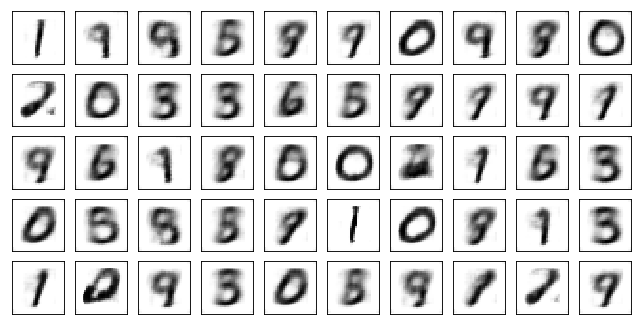

Test losses: 0.8775/0.6932

Train Epoch: 17 [0/50000 (0%)]	Losses  R = 0.8728, D = 0.6928
Train Epoch: 17 [10000/50000 (20%)]	Losses  R = 0.8738, D = 0.6929
Train Epoch: 17 [20000/50000 (40%)]	Losses  R = 0.8747, D = 0.6924
Train Epoch: 17 [30000/50000 (60%)]	Losses  R = 0.8852, D = 0.6924
Train Epoch: 17 [40000/50000 (80%)]	Losses  R = 0.8746, D = 0.6935
Train Epoch: 17 [50000/50000 (100%)]	Losses  R = 0.8793, D = 0.6934


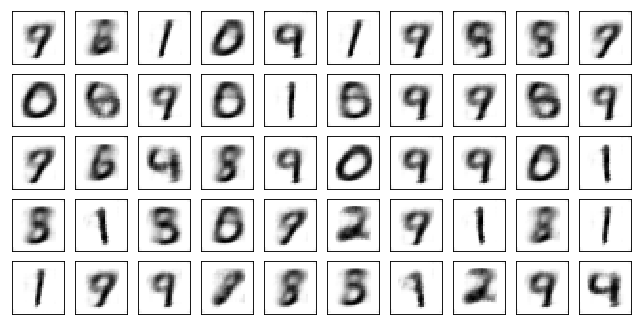

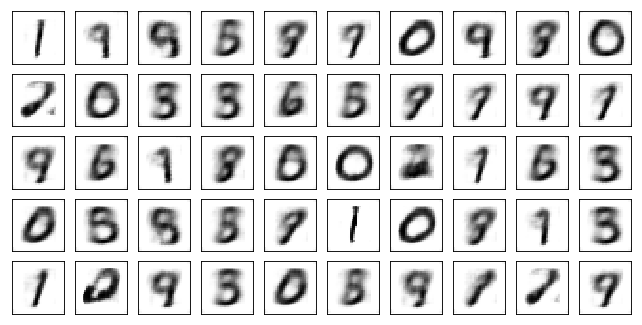

Test losses: 0.8765/0.6931

Train Epoch: 18 [0/50000 (0%)]	Losses  R = 0.8510, D = 0.6929
Train Epoch: 18 [10000/50000 (20%)]	Losses  R = 0.8747, D = 0.6933
Train Epoch: 18 [20000/50000 (40%)]	Losses  R = 0.8869, D = 0.6941
Train Epoch: 18 [30000/50000 (60%)]	Losses  R = 0.8702, D = 0.6929
Train Epoch: 18 [40000/50000 (80%)]	Losses  R = 0.8661, D = 0.6927
Train Epoch: 18 [50000/50000 (100%)]	Losses  R = 0.8623, D = 0.6929


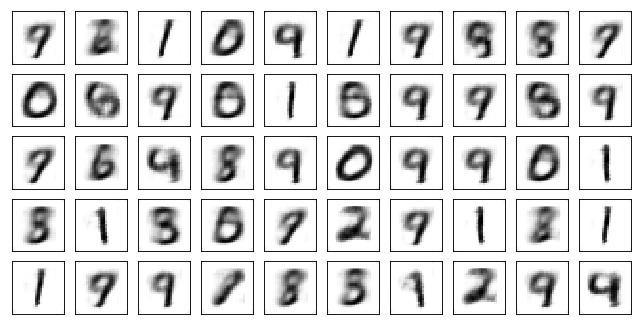

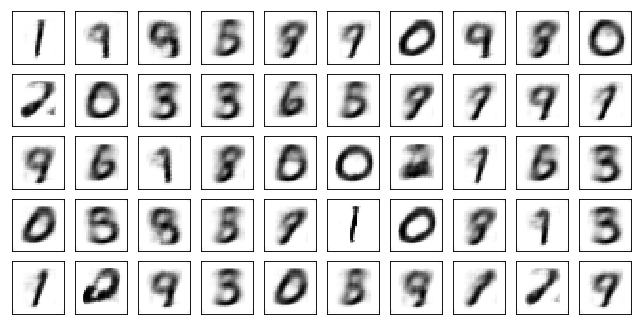

Test losses: 0.8764/0.6931

Train Epoch: 19 [0/50000 (0%)]	Losses  R = 0.8621, D = 0.6935
Train Epoch: 19 [10000/50000 (20%)]	Losses  R = 0.8699, D = 0.6926
Train Epoch: 19 [20000/50000 (40%)]	Losses  R = 0.8821, D = 0.6934
Train Epoch: 19 [30000/50000 (60%)]	Losses  R = 0.8851, D = 0.6931
Train Epoch: 19 [40000/50000 (80%)]	Losses  R = 0.8709, D = 0.6933
Train Epoch: 19 [50000/50000 (100%)]	Losses  R = 0.8725, D = 0.6928


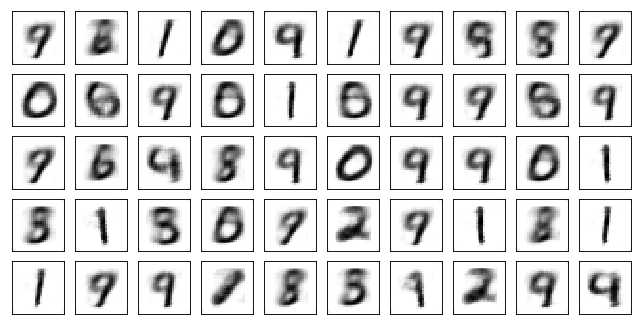

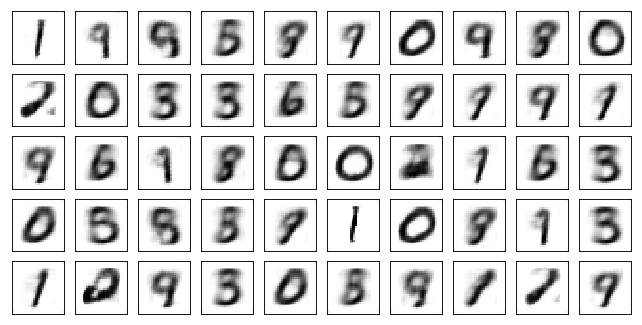

Test losses: 0.8749/0.6930

Train Epoch: 20 [0/50000 (0%)]	Losses  R = 0.8847, D = 0.6929
Train Epoch: 20 [10000/50000 (20%)]	Losses  R = 0.8673, D = 0.6933
Train Epoch: 20 [20000/50000 (40%)]	Losses  R = 0.8625, D = 0.6930
Train Epoch: 20 [30000/50000 (60%)]	Losses  R = 0.8888, D = 0.6929
Train Epoch: 20 [40000/50000 (80%)]	Losses  R = 0.8754, D = 0.6924
Train Epoch: 20 [50000/50000 (100%)]	Losses  R = 0.8639, D = 0.6930


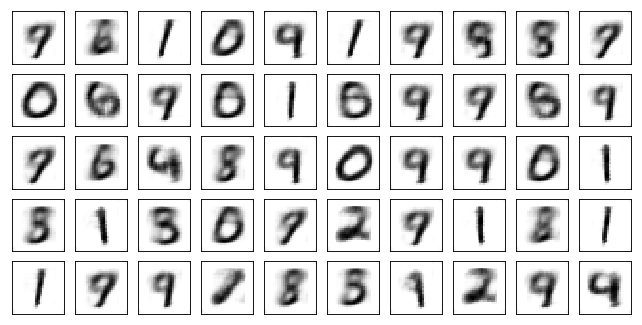

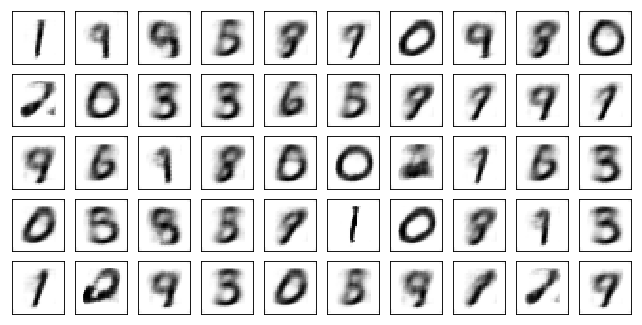

Test losses: 0.8739/0.6930



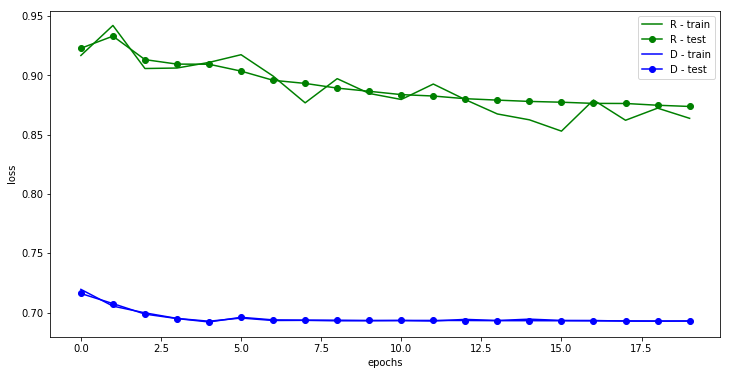

Train Epoch: 21 [0/50000 (0%)]	Losses  R = 0.8799, D = 0.6927
Train Epoch: 21 [10000/50000 (20%)]	Losses  R = 0.8661, D = 0.6931
Train Epoch: 21 [20000/50000 (40%)]	Losses  R = 0.8836, D = 0.6924
Train Epoch: 21 [30000/50000 (60%)]	Losses  R = 0.8582, D = 0.6923
Train Epoch: 21 [40000/50000 (80%)]	Losses  R = 0.8715, D = 0.6918
Train Epoch: 21 [50000/50000 (100%)]	Losses  R = 0.8734, D = 0.6925


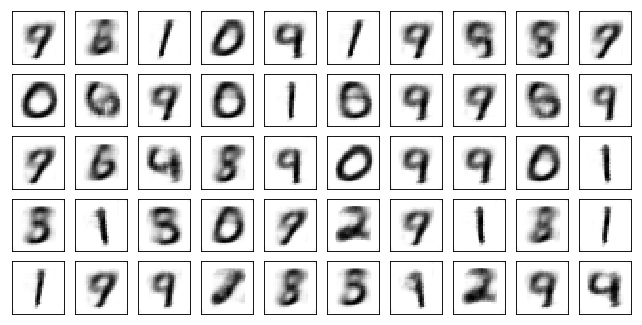

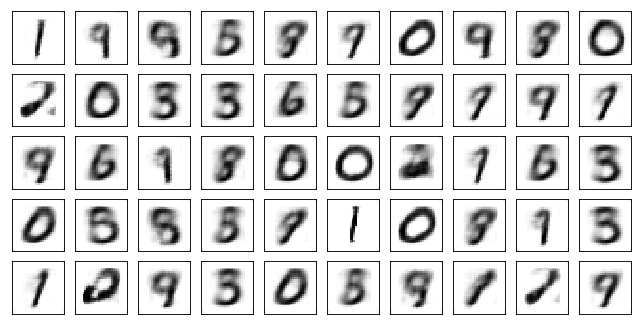

Test losses: 0.8737/0.6929

Train Epoch: 22 [0/50000 (0%)]	Losses  R = 0.8515, D = 0.6932
Train Epoch: 22 [10000/50000 (20%)]	Losses  R = 0.8662, D = 0.6934
Train Epoch: 22 [20000/50000 (40%)]	Losses  R = 0.8944, D = 0.6932
Train Epoch: 22 [30000/50000 (60%)]	Losses  R = 0.8779, D = 0.6931
Train Epoch: 22 [40000/50000 (80%)]	Losses  R = 0.8709, D = 0.6934
Train Epoch: 22 [50000/50000 (100%)]	Losses  R = 0.8636, D = 0.6930


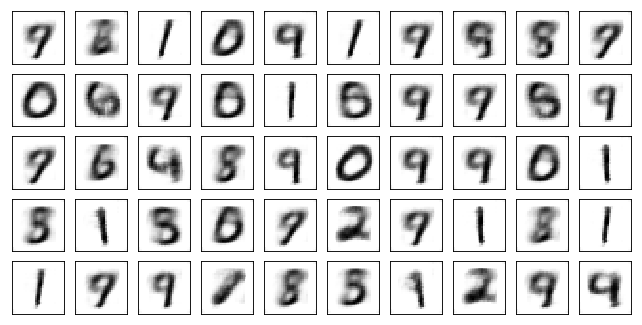

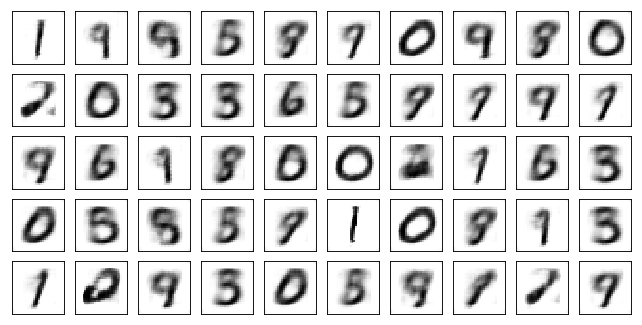

Test losses: 0.8730/0.6929

Train Epoch: 23 [0/50000 (0%)]	Losses  R = 0.8571, D = 0.6927
Train Epoch: 23 [10000/50000 (20%)]	Losses  R = 0.8681, D = 0.6935
Train Epoch: 23 [20000/50000 (40%)]	Losses  R = 0.8683, D = 0.6932
Train Epoch: 23 [30000/50000 (60%)]	Losses  R = 0.8818, D = 0.6934
Train Epoch: 23 [40000/50000 (80%)]	Losses  R = 0.8847, D = 0.6927
Train Epoch: 23 [50000/50000 (100%)]	Losses  R = 0.8737, D = 0.6934


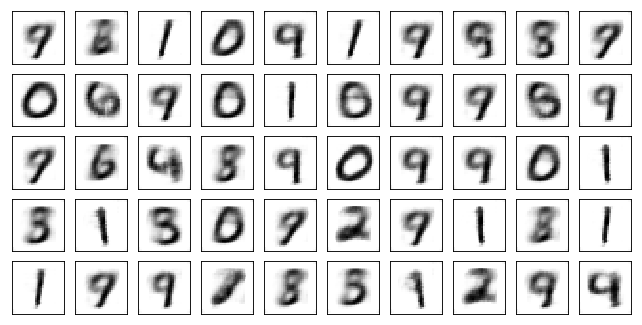

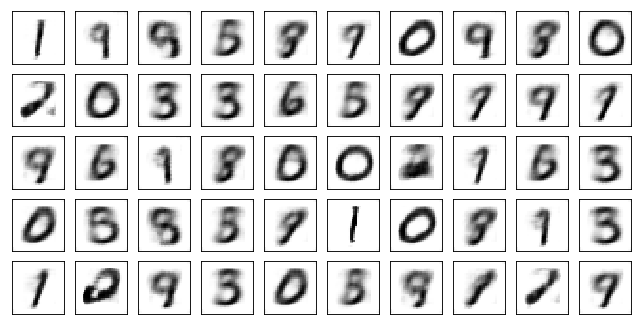

Test losses: 0.8722/0.6929

Train Epoch: 24 [0/50000 (0%)]	Losses  R = 0.8796, D = 0.6931
Train Epoch: 24 [10000/50000 (20%)]	Losses  R = 0.8647, D = 0.6927
Train Epoch: 24 [20000/50000 (40%)]	Losses  R = 0.8777, D = 0.6935
Train Epoch: 24 [30000/50000 (60%)]	Losses  R = 0.8699, D = 0.6923
Train Epoch: 24 [40000/50000 (80%)]	Losses  R = 0.8839, D = 0.6926
Train Epoch: 24 [50000/50000 (100%)]	Losses  R = 0.8843, D = 0.6923


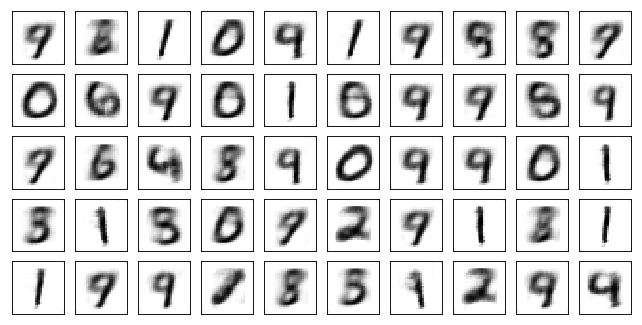

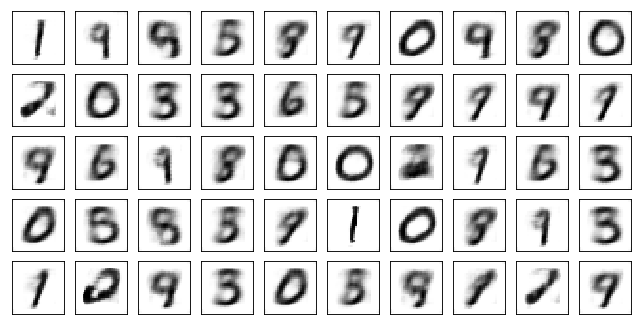

Test losses: 0.8715/0.6929

Train Epoch: 25 [0/50000 (0%)]	Losses  R = 0.8507, D = 0.6928
Train Epoch: 25 [10000/50000 (20%)]	Losses  R = 0.8598, D = 0.6924
Train Epoch: 25 [20000/50000 (40%)]	Losses  R = 0.8819, D = 0.6931
Train Epoch: 25 [30000/50000 (60%)]	Losses  R = 0.8661, D = 0.6937
Train Epoch: 25 [40000/50000 (80%)]	Losses  R = 0.8593, D = 0.6925
Train Epoch: 25 [50000/50000 (100%)]	Losses  R = 0.8811, D = 0.6934


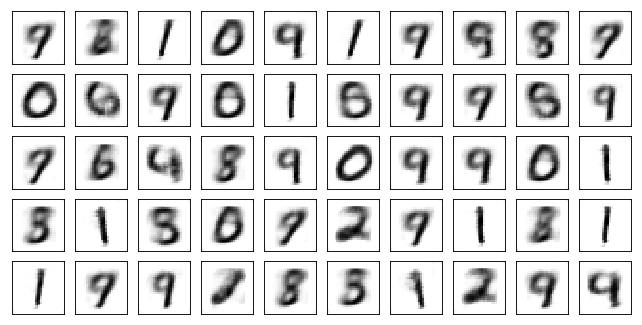

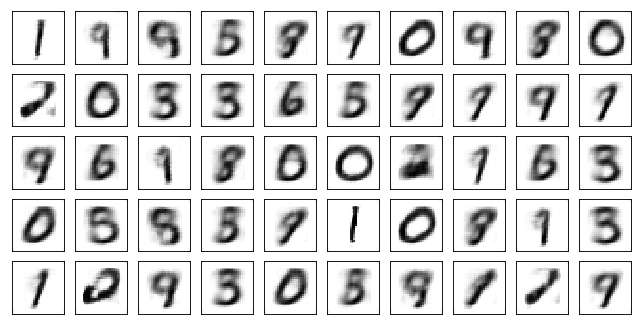

Test losses: 0.8715/0.6928

Train Epoch: 26 [0/50000 (0%)]	Losses  R = 0.8820, D = 0.6927
Train Epoch: 26 [10000/50000 (20%)]	Losses  R = 0.8680, D = 0.6920
Train Epoch: 26 [20000/50000 (40%)]	Losses  R = 0.8700, D = 0.6928
Train Epoch: 26 [30000/50000 (60%)]	Losses  R = 0.8889, D = 0.6924
Train Epoch: 26 [40000/50000 (80%)]	Losses  R = 0.8615, D = 0.6928
Train Epoch: 26 [50000/50000 (100%)]	Losses  R = 0.8680, D = 0.6933


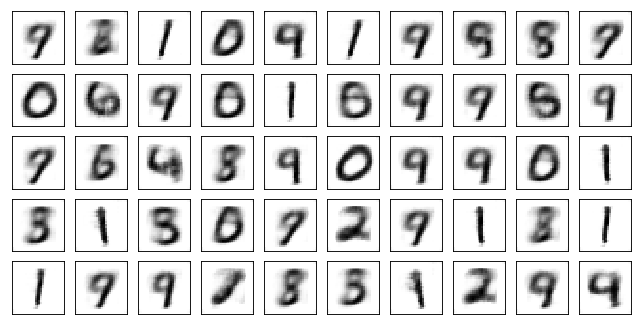

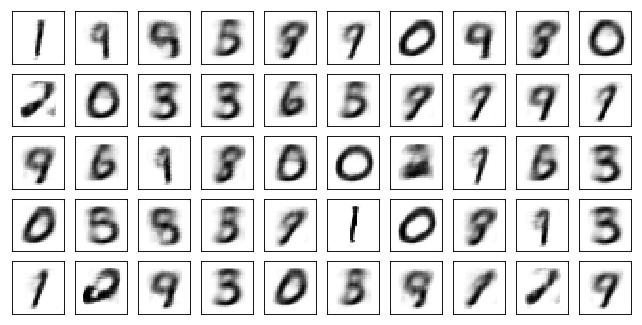

Test losses: 0.8704/0.6929

Train Epoch: 27 [0/50000 (0%)]	Losses  R = 0.8712, D = 0.6926
Train Epoch: 27 [10000/50000 (20%)]	Losses  R = 0.8886, D = 0.6928
Train Epoch: 27 [20000/50000 (40%)]	Losses  R = 0.8529, D = 0.6915
Train Epoch: 27 [30000/50000 (60%)]	Losses  R = 0.8569, D = 0.6927
Train Epoch: 27 [40000/50000 (80%)]	Losses  R = 0.8754, D = 0.6933
Train Epoch: 27 [50000/50000 (100%)]	Losses  R = 0.8481, D = 0.6925


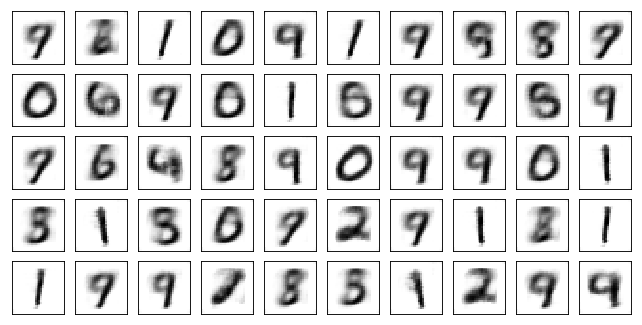

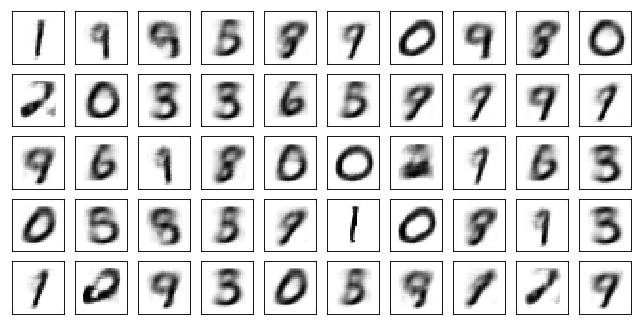

Test losses: 0.8701/0.6929

Train Epoch: 28 [0/50000 (0%)]	Losses  R = 0.8719, D = 0.6939
Train Epoch: 28 [10000/50000 (20%)]	Losses  R = 0.8611, D = 0.6931
Train Epoch: 28 [20000/50000 (40%)]	Losses  R = 0.8590, D = 0.6938
Train Epoch: 28 [30000/50000 (60%)]	Losses  R = 0.8871, D = 0.6924
Train Epoch: 28 [40000/50000 (80%)]	Losses  R = 0.8773, D = 0.6925
Train Epoch: 28 [50000/50000 (100%)]	Losses  R = 0.8661, D = 0.6922


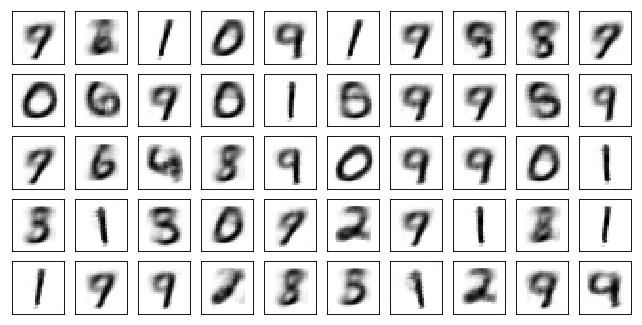

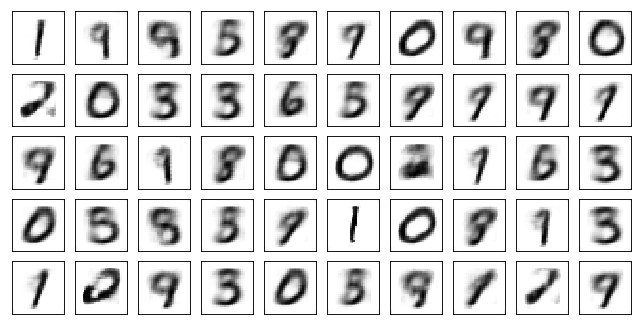

Test losses: 0.8702/0.6928

Train Epoch: 29 [0/50000 (0%)]	Losses  R = 0.8600, D = 0.6925
Train Epoch: 29 [10000/50000 (20%)]	Losses  R = 0.8919, D = 0.6934
Train Epoch: 29 [20000/50000 (40%)]	Losses  R = 0.8707, D = 0.6940
Train Epoch: 29 [30000/50000 (60%)]	Losses  R = 0.8641, D = 0.6927
Train Epoch: 29 [40000/50000 (80%)]	Losses  R = 0.8575, D = 0.6934
Train Epoch: 29 [50000/50000 (100%)]	Losses  R = 0.8641, D = 0.6934


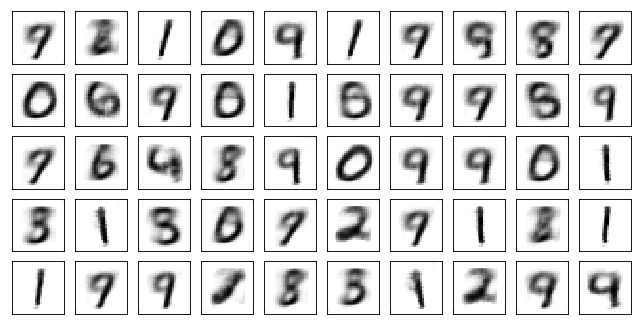

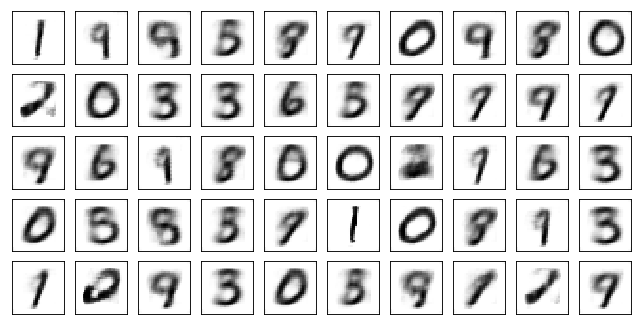

Test losses: 0.8693/0.6929

Train Epoch: 30 [0/50000 (0%)]	Losses  R = 0.8557, D = 0.6937
Train Epoch: 30 [10000/50000 (20%)]	Losses  R = 0.8530, D = 0.6935
Train Epoch: 30 [20000/50000 (40%)]	Losses  R = 0.8771, D = 0.6935
Train Epoch: 30 [30000/50000 (60%)]	Losses  R = 0.8810, D = 0.6934
Train Epoch: 30 [40000/50000 (80%)]	Losses  R = 0.8538, D = 0.6934
Train Epoch: 30 [50000/50000 (100%)]	Losses  R = 0.8560, D = 0.6926


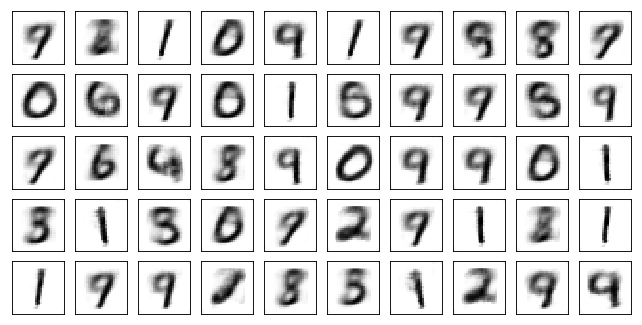

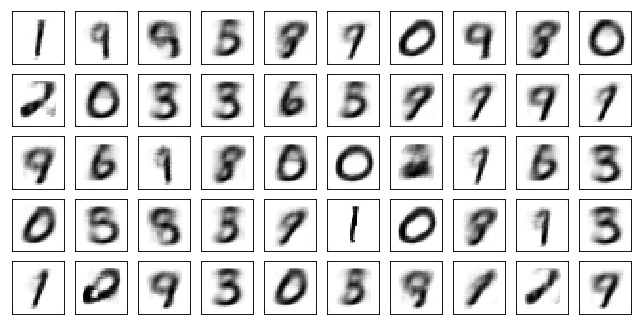

Test losses: 0.8690/0.6929



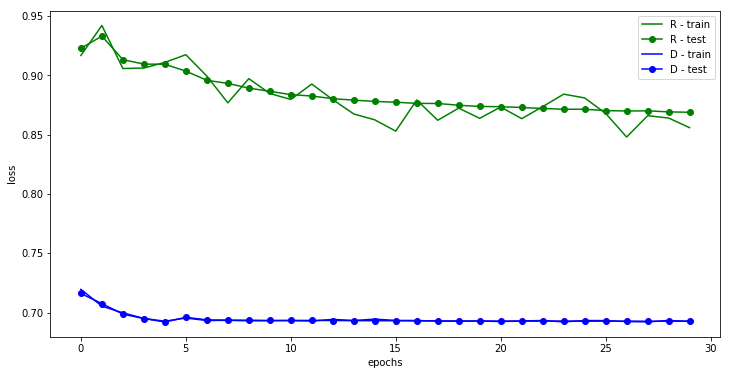

In [17]:
for epoch in range(1, 31):
    encoder.train()
    decoder.train()
    D.train()
    
    train(epoch, train_log)
    
    encoder.eval()
    decoder.eval()
    D.eval()
    
    test(valid_loader, epoch, test_log)
    
    if epoch % 10 == 0:
        plot(list(zip(*train_log)), list(zip(*test_log)))

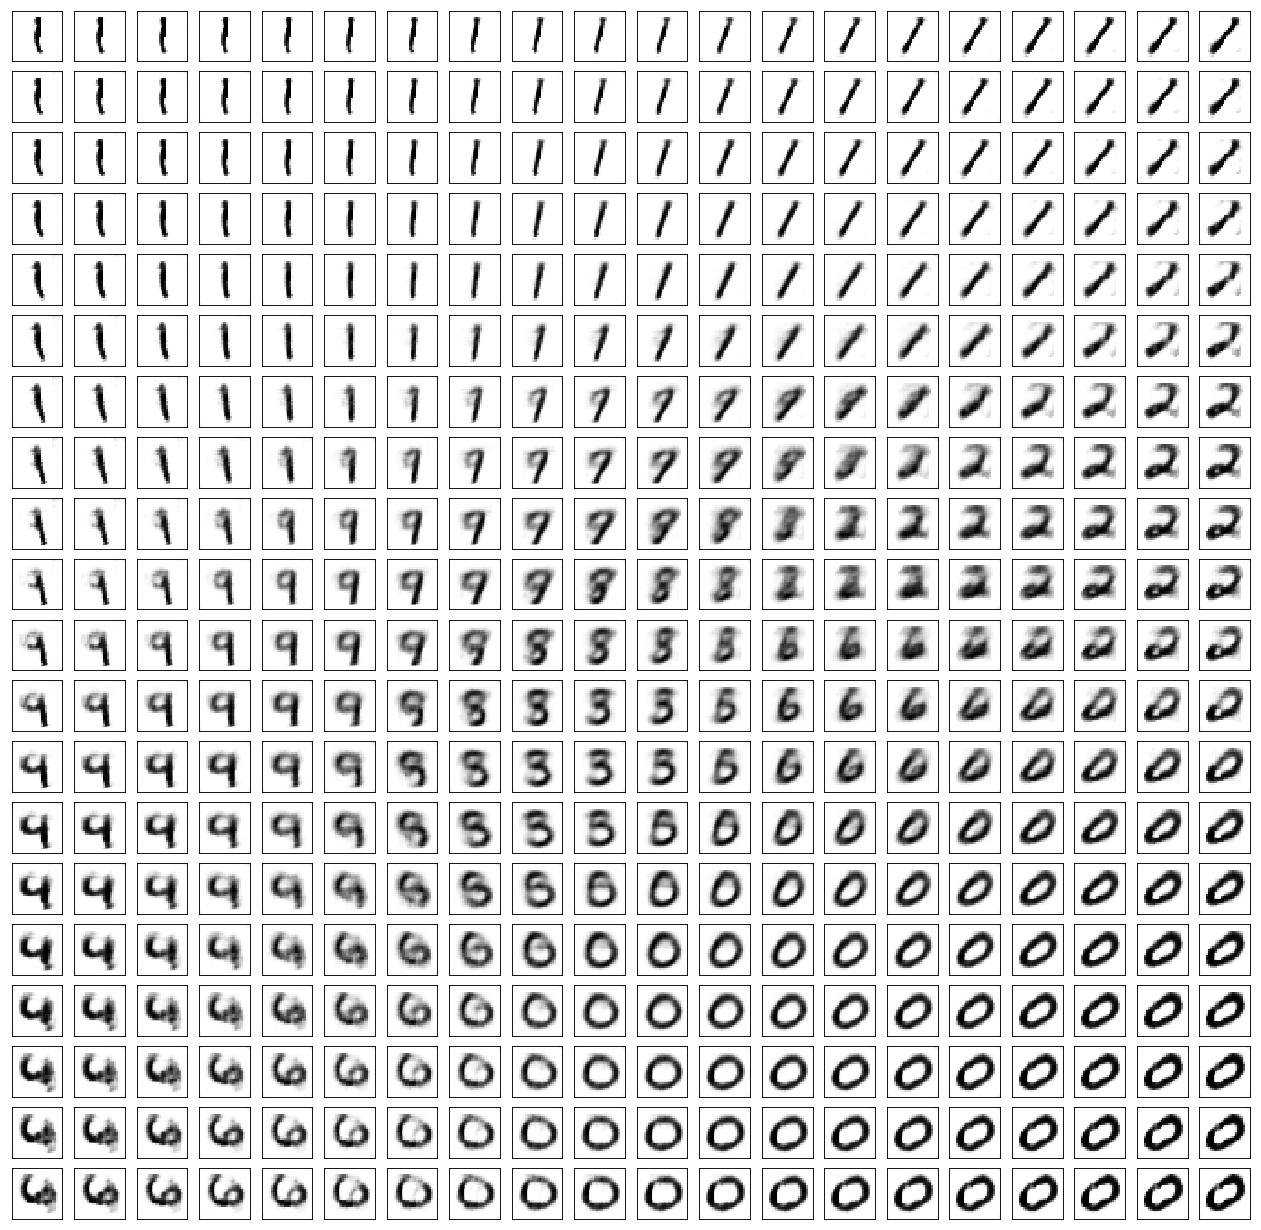

In [18]:
decoder.eval()
n_points = 20
import itertools
data2 = torch.zeros(n_points*n_points,2).cuda()
for t, (i, j) in enumerate(itertools.product(np.linspace(-3,3,n_points),np.linspace(-3,3,n_points))):
    data2[t,:]=torch.tensor((i,j))
dec2 = decoder(data2)
plot_mnist(dec2.detach().cpu().numpy(), (n_points, n_points))